In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

In [36]:
pickle_path = "grad_results_prefix200_gen100.pkl"
with open(pickle_path, 'rb') as f:
    results = pickle.load(f)
df = pd.DataFrame(results)

In [38]:
def plot_heatmap(val_key):
    # Plot heatmaps of grad_norm for each projection type (Q, K, V, O), averaged over data_index
    proj_types = ['q_proj', 'k_proj', 'v_proj', 'o_proj']
    
    # Get unique layers and heads for axis labels
    layers = np.sort(df['layer'].unique())
    heads = np.sort(df['head'].unique())
    
    # Prepare the data for each projection type
    pivot_tables = {}
    for proj in proj_types:
        sub_df = df[df['proj_type'] == proj]
        pivot = sub_df.pivot_table(
            index='layer', columns='head', values=val_key, aggfunc='mean')
        pivot_tables[proj] = pivot
    
    # Find global vmin/vmax for colorbar
    vmin = min(pivot.min().min() for pivot in pivot_tables.values())
    vmax = max(pivot.max().max() for pivot in pivot_tables.values())
    
    fig, axes = plt.subplots(4, 1, figsize=(8, 4.5), sharex=True, sharey=True)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    
    for i, proj in enumerate(proj_types):
        ax = axes[i]
        sns.heatmap(pivot_tables[proj], ax=ax, vmin=vmin, vmax=vmax, cmap='viridis', cbar=(i==3), cbar_ax=cbar_ax if i==3 else None)
        ax.set_title(f"{proj[0].upper()} Projection", fontsize=10)
        ax.set_ylabel("Layer")
        if i == 3:
            ax.set_xlabel("Head")
        else:
            ax.set_xlabel("")
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()
    

/tmp/ipykernel_1404246/3113474242.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


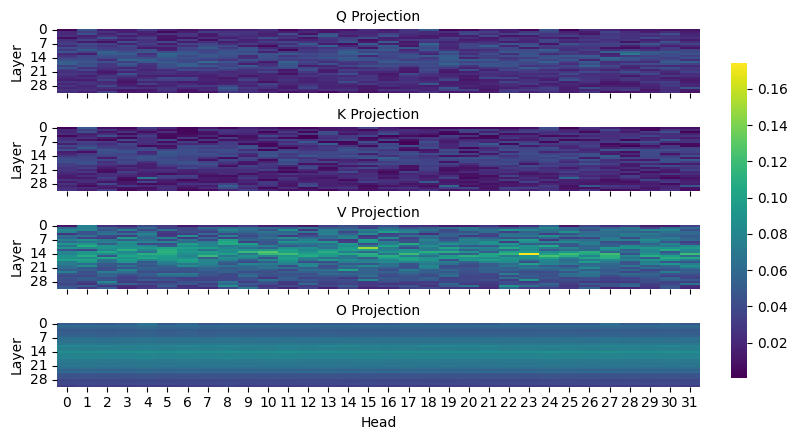

In [39]:
plot_heatmap('grad_norm')

/tmp/ipykernel_1404246/3113474242.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


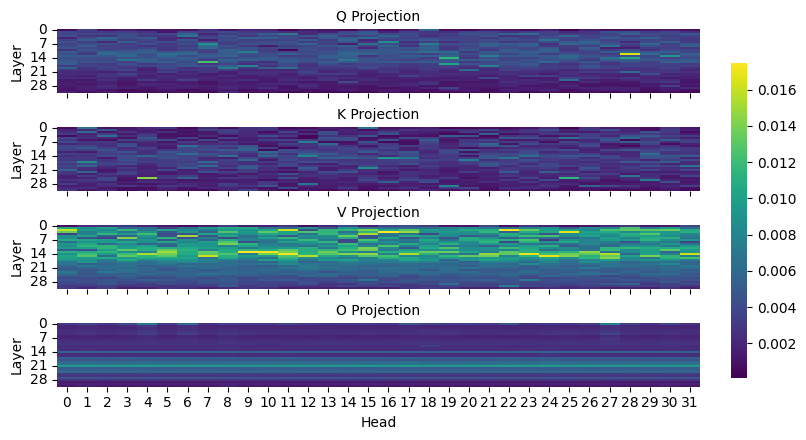

In [40]:
plot_heatmap('grad_max')

In [41]:
pickle_path = "grad_results_lowprop_prefix200_gen100.pkl"
with open(pickle_path, 'rb') as f:
    results = pickle.load(f)
df = pd.DataFrame(results)

/tmp/ipykernel_1404246/3113474242.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


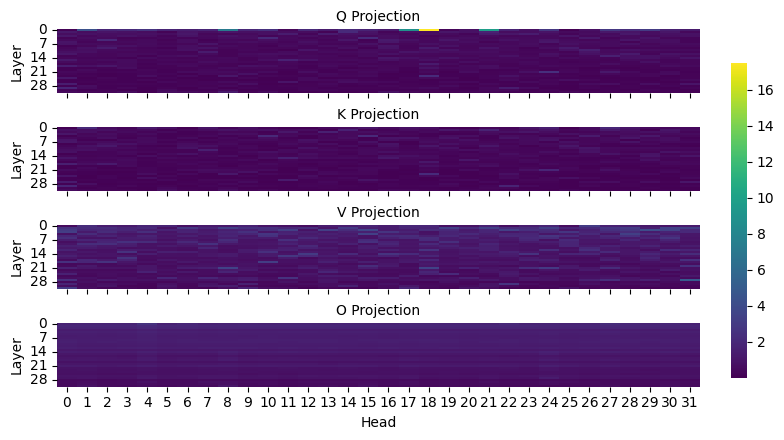

In [42]:
plot_heatmap('grad_norm')

/tmp/ipykernel_1404246/3113474242.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


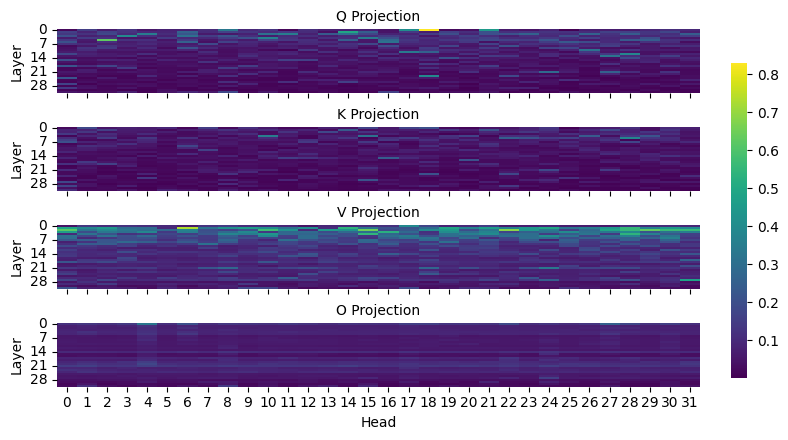

In [43]:
plot_heatmap('grad_max')

# PCA Plots

In [44]:
# Collect layer/head vectors for proj_type='v_proj' from both pickle files, run PCA, and plot datapoints colored by proportion type
import pandas as pd
import numpy as np
import pickle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_vectors(pickle_path, label):
    with open(pickle_path, 'rb') as f:
        results = pickle.load(f)
    df = pd.DataFrame(results)
    df_vproj = df[df['proj_type'] == 'v_proj']
    layers = np.sort(df_vproj['layer'].unique())
    heads = np.sort(df_vproj['head'].unique())
    n_layer = len(layers)
    n_head = len(heads)
    vectors = []
    indices = []
    for data_index in df_vproj['data_index'].unique():
        sub_df = df_vproj[df_vproj['data_index'] == data_index]
        # Create matrix of shape (n_layer, n_head) for grad_norm
        mat = np.full((n_layer, n_head), np.nan)
        for _, row in sub_df.iterrows():
            l_idx = np.where(layers == row['layer'])[0][0]
            h_idx = np.where(heads == row['head'])[0][0]
            mat[l_idx, h_idx] = row['grad_max']
        vectors.append(mat.flatten())
        indices.append(data_index)
    return np.array(vectors), [label]*len(vectors), indices

# Collect vectors for both files
vec_low, label_low, idx_low = collect_vectors('grad_results_lowprop_prefix200_gen100.pkl', 'low')
vec_high, label_high, idx_high = collect_vectors('grad_results_prefix200_gen100.pkl', 'high')

# Concatenate all vectors and labels
X = np.concatenate([vec_low, vec_high], axis=0)
labels = np.array(label_low + label_high)

# Subsampling
sample_size = 500  # or any number you prefer
if X.shape[0] > sample_size:
    rng = np.random.default_rng(42)  # for reproducibility
    sample_idx = rng.choice(X.shape[0], sample_size, replace=False)
    X_sample = X[sample_idx]
    labels_sample = labels[sample_idx]
else:
    X_sample = X
    labels_sample = labels

# Run PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

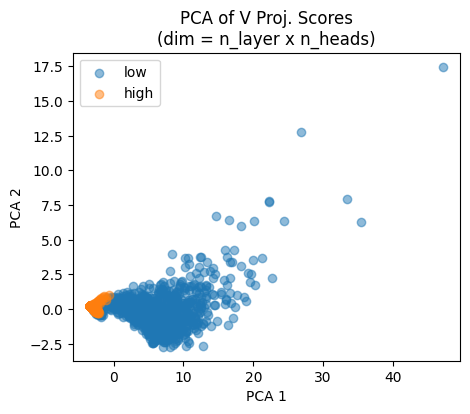

In [46]:
# Plot
plt.figure(figsize=(5,4))
for prop in ['low', 'high']:
    mask = labels == prop
    plt.scatter(X_pca[mask,0], X_pca[mask,1], label=prop, alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of V Proj. Scores\n(dim = n_layer x n_heads)')
plt.legend()
plt.show()